In [1]:
import os

import copy
import random
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc #, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as st
from scipy.stats import norm
from tabulate import tabulate

from logging_utils import *
from logging_utils import myLogger, print_log, close_loggers 

from plot_utils import plot_mean_ROC, plot_mean_PR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
SEED = 1970
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

color_index = list(mcolors.CSS4_COLORS)
colors = mcolors.CSS4_COLORS

data_path = './data/'
mean_metrics = 'mean_metrics.csv'
mean_metrics_VA = 'mean_metrics_231231.csv'

mean_metrics_cols = ['date', 'model', 'image_size', 'batch_size', 'channel', 'test_set','roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metrics_cols = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metric_name = ['ROC AUC', 'PR AUC', 'F1', 'Precision', 'Recall']
test_label = ['test_loc', 'test_NoL']
test_classes = {'test_loc' : [5812, 336], 'test_NoL' : [3742, 835]}

# channel_label = ['RGB', '3', 'EI', 'MI', '5']
channel_label = ['RGB', 'HSV', 'EI', 'MI', '5']
channel_label_alt = ['RGB', 'HSV', 'HSV + EI', 'HSV + MI', 'HSV + EI + MI']

In [3]:
df_mean_metrics = pd.read_csv(f'{data_path}/{mean_metrics}')
df_mean_metrics.shape

(120, 12)

In [4]:
df_mean_metrics_VA = pd.read_csv(f'{data_path}/{mean_metrics_VA}')
df_mean_metrics_VA.dropna(inplace = True)
df_mean_metrics_VA.shape

(100, 12)

In [5]:
df_mean_metrics.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid
110,20231227,v2b0,128,64,RGB,0.683322,0.363096,0.364106,0.394958,0.337725,test_NoL,2cc08667-379e-4ba9-9801-5931d627c8e6
111,20231227,v2b0,128,64,3,0.696798,0.400200,0.418795,0.365093,0.491018,test_NoL,2cc08667-379e-4ba9-9801-5931d627c8e6
112,20231227,v2b0,128,64,EI,0.699973,0.393755,0.409596,0.400458,0.419162,test_NoL,2cc08667-379e-4ba9-9801-5931d627c8e6
113,20231227,v2b0,128,64,MI,0.691418,0.390128,0.407446,0.358508,0.471856,test_NoL,2cc08667-379e-4ba9-9801-5931d627c8e6
114,20231227,v2b0,128,64,5,0.700928,0.386646,0.403397,0.362250,0.455090,test_NoL,2cc08667-379e-4ba9-9801-5931d627c8e6
115,20231227,v2b0,128,64,RGB,0.875844,0.356697,0.391111,0.389381,0.392857,test_loc,2cc08667-379e-4ba9-9801-5931d627c8e6
116,20231227,v2b0,128,64,3,0.877764,0.343233,0.371882,0.300366,0.488095,test_loc,2cc08667-379e-4ba9-9801-5931d627c8e6
117,20231227,v2b0,128,64,EI,0.870997,0.338677,0.345342,0.296375,0.413690,test_loc,2cc08667-379e-4ba9-9801-5931d627c8e6
118,20231227,v2b0,128,64,MI,0.881691,0.356573,0.358852,0.300000,0.446429,test_loc,2cc08667-379e-4ba9-9801-5931d627c8e6
119,20231227,v2b0,128,64,5,0.865262,0.338890,0.341860,0.280534,0.437500,test_loc,2cc08667-379e-4ba9-9801-5931d627c8e6


In [6]:
df_mean_metrics_VA.tail(10)

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid
130,20231223,vgg16,256,64,RGB,0.725670,0.421800,0.438517,0.352215,0.580838,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323
131,20231223,vgg16,256,64,3,0.729804,0.433395,0.431764,0.323758,0.647904,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323
132,20231223,vgg16,256,64,EI,0.718551,0.419581,0.427071,0.316244,0.657485,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323
133,20231223,vgg16,256,64,MI,0.712765,0.417779,0.431955,0.352807,0.556886,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323
134,20231223,vgg16,256,64,5,0.717374,0.413925,0.427350,0.323674,0.628743,test_NoL,ba4ecd33-de8e-4600-9ea2-1c76bff89323
135,20231223,vgg16,256,64,RGB,0.883910,0.410755,0.393684,0.304560,0.556548,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
136,20231223,vgg16,256,64,3,0.883286,0.382386,0.365572,0.260430,0.613095,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
137,20231223,vgg16,256,64,EI,0.884267,0.396170,0.372378,0.263614,0.633929,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
138,20231223,vgg16,256,64,MI,0.886443,0.397081,0.401309,0.316695,0.547619,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
139,20231223,vgg16,256,64,5,0.887158,0.392524,0.383459,0.280220,0.607143,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323


In [7]:
uuid_left = set(df_mean_metrics.uuid)
uuid_right = set(df_mean_metrics_VA.uuid)
uuid_add = uuid_right - uuid_left
# print(uuid_add)

df_mean_metrics_all = pd.concat([df_mean_metrics, df_mean_metrics_VA.loc[df_mean_metrics_VA.uuid.isin(uuid_add)]], axis = 0).reindex()
print(df_mean_metrics_all.shape[0])

220


In [8]:
df_mean_metrics_all.loc[df_mean_metrics_all.channel == '3', 'channel'] = 'HSV'
df_mean_metrics_all

,date,model,image_size,batch_size,channel,roc_auc,pr_auc,f1,precision,recall,test_set,uuid
0,20231127,v1b0,256,128,RGB,0.693207,0.486560,0.415094,0.327562,0.566467,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f
1,20231127,v1b0,256,128,HSV,0.693431,0.483368,0.408954,0.319220,0.568862,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f
2,20231127,v1b0,256,128,EI,0.687453,0.470314,0.407180,0.336193,0.516168,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f
3,20231127,v1b0,256,128,MI,0.683484,0.478675,0.411845,0.332353,0.541317,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f
4,20231127,v1b0,256,128,5,0.691385,0.481461,0.407792,0.319322,0.564072,test_NoL,c80b8178-e65b-483d-95b1-d86952ea8e8f
...,...,...,...,...,...,...,...,...,...,...,...,...
135,20231223,vgg16,256,64,RGB,0.883910,0.410755,0.393684,0.304560,0.556548,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
136,20231223,vgg16,256,64,HSV,0.883286,0.382386,0.365572,0.260430,0.613095,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
137,20231223,vgg16,256,64,EI,0.884267,0.396170,0.372378,0.263614,0.633929,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323
138,20231223,vgg16,256,64,MI,0.886443,0.397081,0.401309,0.316695,0.547619,test_loc,ba4ecd33-de8e-4600-9ea2-1c76bff89323


In [9]:
def plot_metrics(df_mean_metrics):
    df_mean = df_mean_metrics.groupby(['test_set','channel'])['roc_auc'].mean()
    df_mean_all = df_mean_metrics.groupby(['test_set','channel'])[metrics_cols].mean()

    for mi, mn in enumerate(metrics_cols):  
        fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
        for ti, tn in enumerate(test_label):
            metrics_dict = dict(df_mean_all.loc[test_label[ti]][mn])
            rearr = {}
            for ch in channel_label:
                rearr[ch] = metrics_dict[ch]
            x = list(rearr.keys())
            y = list(rearr.values())
            max_x = np.argmax(y)
            max_y = np.array(y).max()
            ax.plot(max_x, max_y, marker = 'o')
            ax.plot(x, y,
                    color = colors[color_index[ti]],
                    label = f"{mn} for {tn}",
                    lw=2,
                    alpha = 0.9)   
        ax.set(xlabel = "Channels",
                ylabel = mn,
                title = f"Mean {mn} for all channels")   
        ax.legend(loc="lower right")
        plt.show()

In [10]:
def print_metrics_CI(df_mean_metrics_all):
    for ti, tn in enumerate(test_label):
        n_samples = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn)].shape[0]
        print(f'\nTest set - {tn}, {test_classes[tn][0]} bening and {test_classes[tn][1]} malignant samples')
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            for ci, ch in enumerate(channel_label):
                df_temp = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn) & (df_mean_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc=np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
            print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))

In [11]:
# print_metrics_CI(df_mean_metrics)

In [12]:
print_metrics_CI(df_mean_metrics_all)


Test set - test_loc, 5812 bening and 336 malignant samples
22 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    86.59%    │     (85.85%, 87.32%)      │
│ HSV           │ -> 86.83% <- │     (86.38%, 87.28%)      │
│ HSV + EI      │    86.55%    │     (86.03%, 87.07%)      │
│ HSV + MI      │    86.79%    │     (86.24%, 87.35%)      │
│ HSV + EI + MI │    86.44%    │     (85.87%, 87.02%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │ -> 34.52% <- │     (32.54%, 36.50%)      │
│ HSV           │    33.62%    │     (32.19%, 35.04%)      │
│ HSV + EI      │    33.80%    │     (32.23%, 35.36%

In [13]:
# plot_metrics(df_mean_metrics)

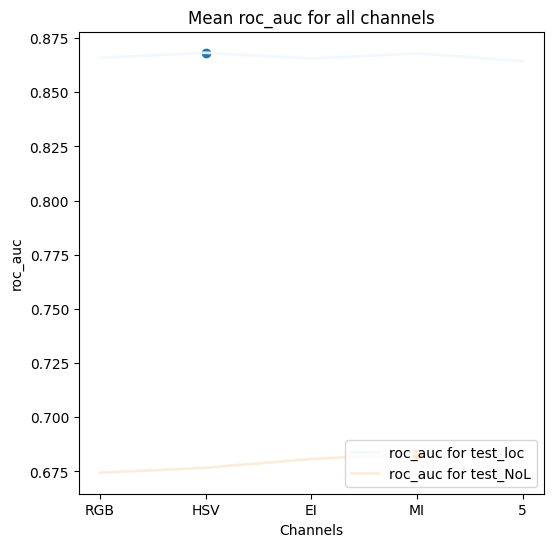

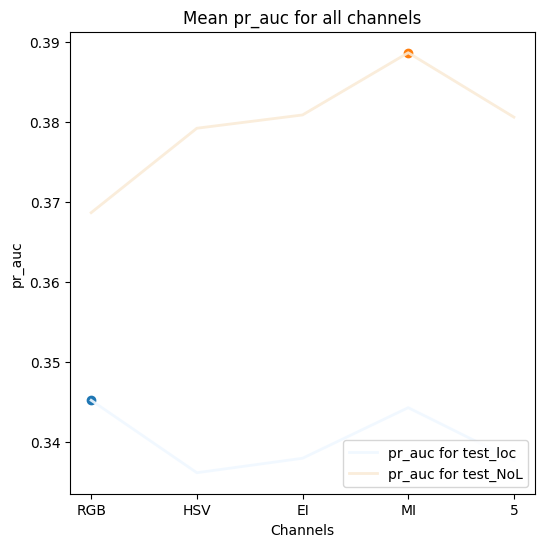

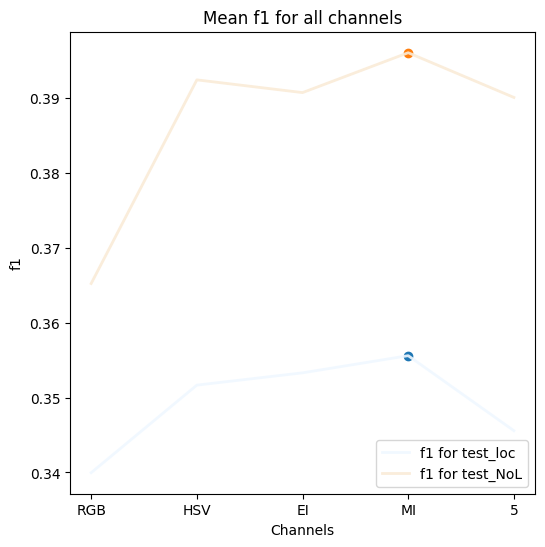

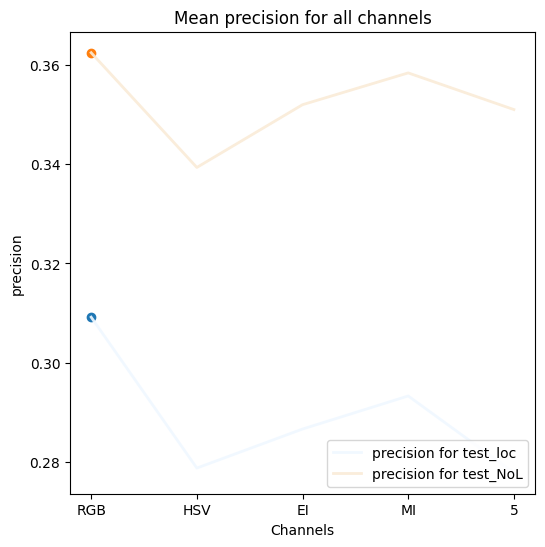

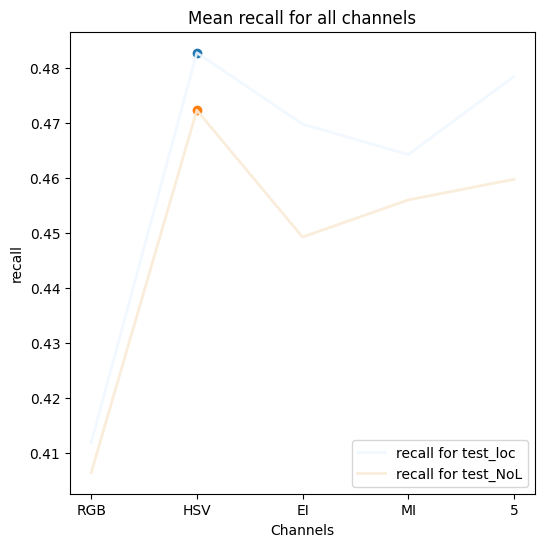

In [14]:
plot_metrics(df_mean_metrics_all)

[]

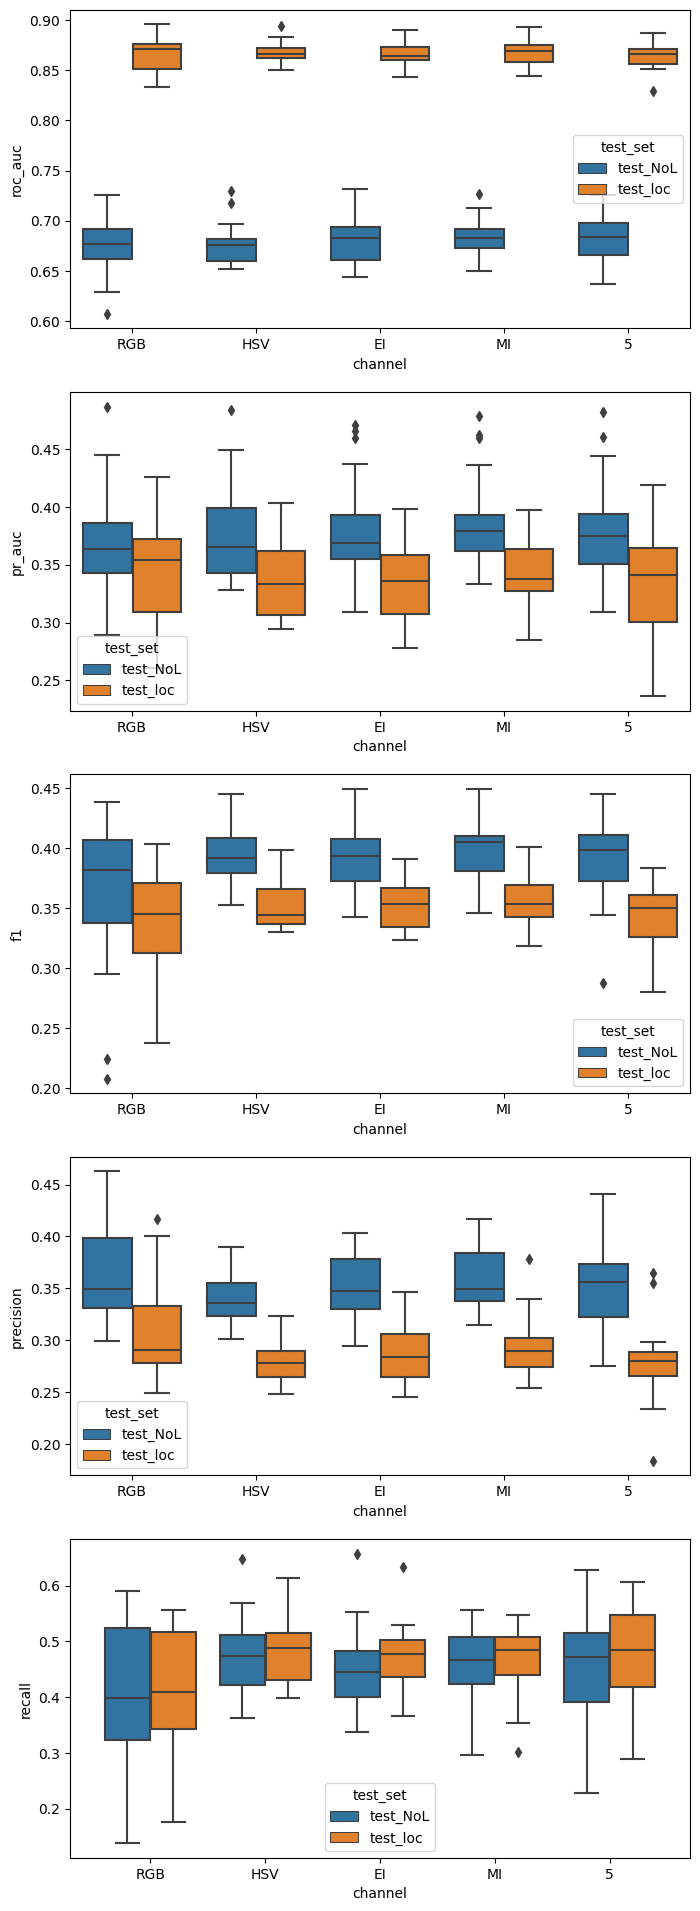

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'test_set', ax = axs[i])

plt.plot()


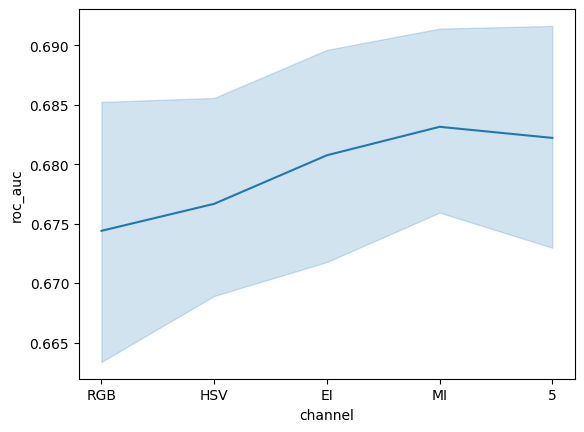

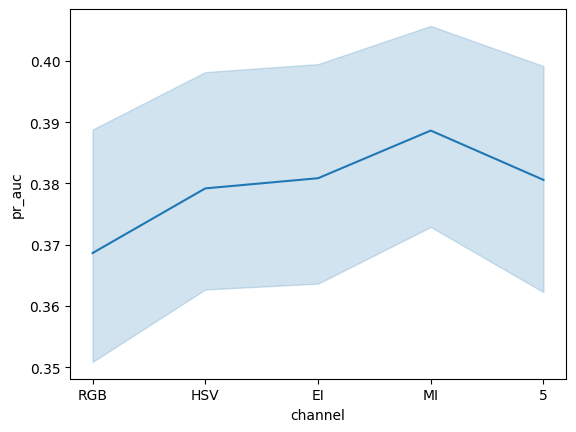

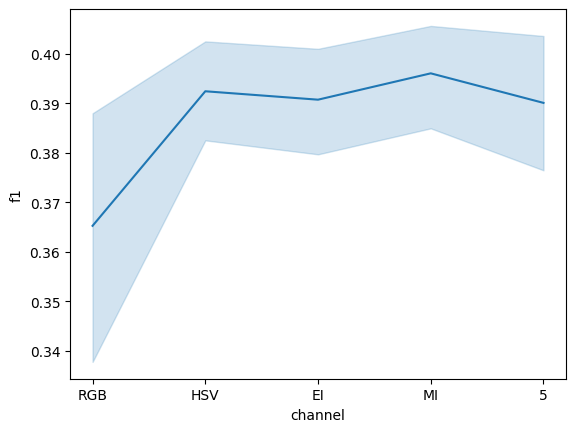

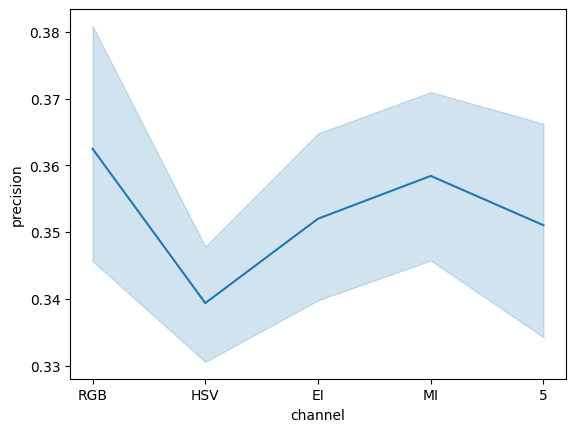

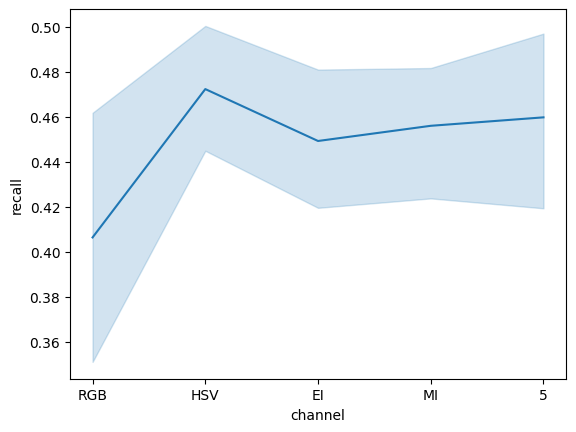

In [16]:
for metr in metrics_cols:
    sns.lineplot(data = df_mean_metrics_all.loc[df_mean_metrics_all.test_set == 'test_NoL'], x = "channel", y = metr)
    plt.show()

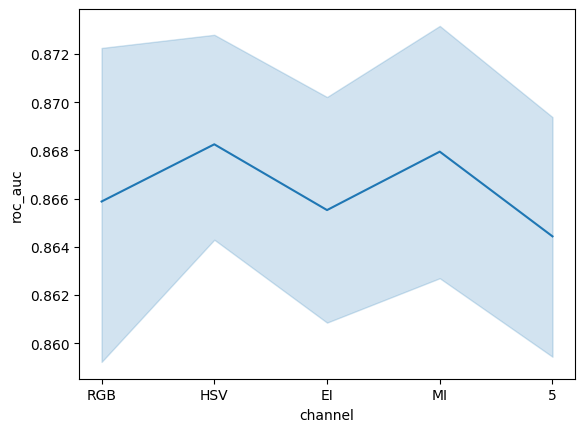

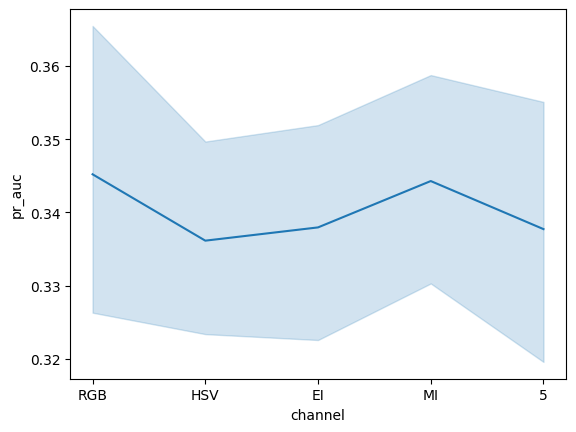

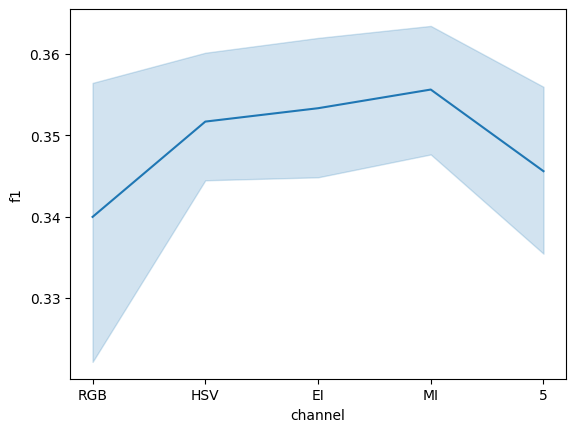

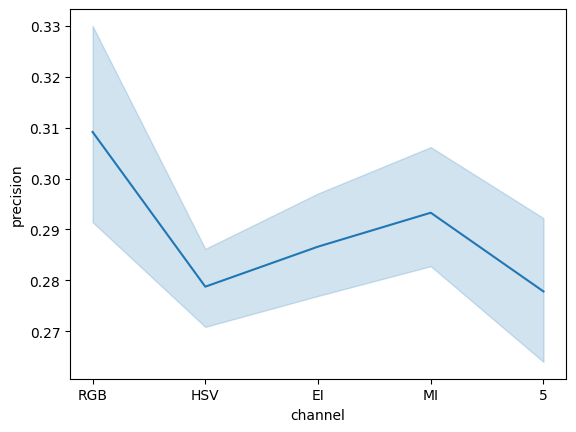

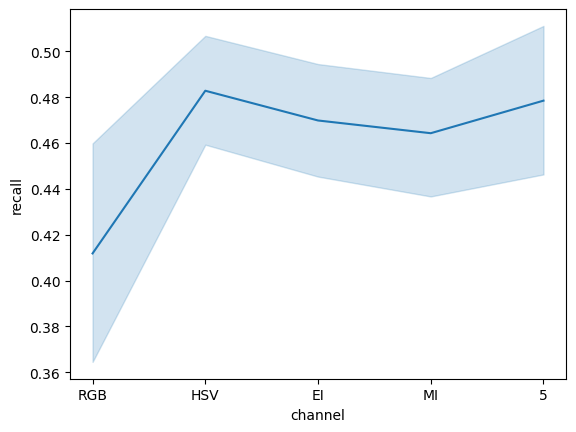

In [17]:
for metr in metrics_cols:
    sns.lineplot(data = df_mean_metrics_all.loc[df_mean_metrics_all.test_set == 'test_loc'], x = "channel", y = metr)
    plt.show()